In [1]:
from collections import namedtuple
from functools import partial
import os
import sys

import pandas as pd
import xml.etree.ElementTree as ET


sys.path.append('..')

from tagger import ClarinTagger

In [2]:
Token = namedtuple('Token', ['text', 'tag'])

### Load data

In [3]:
data_path = '../wiki_data'

train_paths = [os.path.join(data_path, 'wiki_train_34_categories_data_processed_wcrft2'),
               os.path.join(data_path, 'wiki_train_34_categories_data_processed_morphoDita'),
               os.path.join(data_path, 'wiki_train_34_categories_data_processed_krnnt')
              ]

test_paths = [os.path.join(data_path, 'wiki_test_34_categories_data_processed_wcrft2'),
              os.path.join(data_path, 'wiki_test_34_categories_data_processed_morphoDita'),
              os.path.join(data_path, 'wiki_test_34_categories_data_processed_krnnt')
             ]

In [4]:
def load_data(path):
    df_data = pd.DataFrame()
    with os.scandir(path) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                df_data = df_data.append(pd.read_pickle(entry.path), ignore_index=True)
    df_data = df_data[~df_data['cat'].isin(['contents', 'dublin', 'handle', 'metadata', 'license.txt'])]
    return df_data

In [5]:
def load_tagged_data(paths):
    data = pd.DataFrame()
    for p in paths:
        df = load_data(p)
        if 'train' in p:
            df['set'] = "train"
        elif 'test' in p:
            df['set'] = "test"
        else:
            raise ValueError("Invalid folder name")
        df['tagger'] = p.split('_')[-1]
        data = pd.concat([data, df])
    return data

In [6]:
data = load_tagged_data(train_paths + test_paths)

In [7]:
data.head()

,text,cat,filename,tokens,set,tagger
0,"Pierwiastki biofilne, pierwiastki biogenne, nu...",Pierwiastki-chemiczne,Pierwiastki-chemiczne_1857348.txt,"[(pierwiastek, subst:pl:nom:m3), (biofilny, ad...",train,wcrft2
1,"Robocizna, to praca włożona w wykonanie określ...",Rachunkowosc,Rachunkowosc_1691781.txt,"[(robocizna, subst:sg:nom:f), (,, interp), (to...",train,wcrft2
2,Jonathan Cheecho (ur. 15 lipca 1980 w Moose Fa...,Pilka-nozna,Pilka-nozna_3022011.txt,"[(Jonathan, ign), (Cheecho, ign), ((, interp),...",train,wcrft2
3,Florin Daniel Bratu (ur. 2 stycznia 1980 w Buk...,Pilka-nozna,Pilka-nozna_2293521.txt,"[(Florin, ign), (Daniel, subst:sg:nom:m1), (br...",train,wcrft2
4,"Iterb (Yb, łac. ytterbium) – pierwiastek chemi...",Pierwiastki-chemiczne,Pierwiastki-chemiczne_30496.txt,"[(iterb, subst:sg:nom:m3), ((, interp), (Yb, i...",train,wcrft2


In [65]:
print(data.head().to_latex())

\begin{tabular}{lllllll}
\toprule
{} &                                               text &                    cat &                           filename &                                             tokens &    set &  tagger \\
\midrule
0 &  Pierwiastki biofilne, pierwiastki biogenne, nu... &  Pierwiastki-chemiczne &  Pierwiastki-chemiczne\_1857348.txt &  [(pierwiastek, subst:pl:nom:m3), (biofilny, ad... &  train &  wcrft2 \\
1 &  Robocizna, to praca włożona w wykonanie określ... &           Rachunkowosc &           Rachunkowosc\_1691781.txt &  [(robocizna, subst:sg:nom:f), (,, interp), (to... &  train &  wcrft2 \\
2 &  Jonathan Cheecho (ur. 15 lipca 1980 w Moose Fa... &            Pilka-nozna &            Pilka-nozna\_3022011.txt &  [(Jonathan, ign), (Cheecho, ign), ((, interp),... &  train &  wcrft2 \\
3 &  Florin Daniel Bratu (ur. 2 stycznia 1980 w Buk... &            Pilka-nozna &            Pilka-nozna\_2293521.txt &  [(Florin, ign), (Daniel, subst:sg:nom:m1), (br... &  train &  wc

### Filtering

In [8]:
def filter_tags(tokens, tags=None):
    if tags and tokens:
        return [x for x in tokens if x.tag is not None and x.tag.split(':')[0] in tags]
    else:
        return [x for x in tokens]

In [9]:
def text_from_tokens(tokens):
    return [x.text for x in tokens]

In [10]:
def get_filtered_text(data, tags):
    data['filtered_tokens'] = data['tokens'].apply(partial(filter_tags, tags=tags))
    data['filtered_tokens_text'] = data['filtered_tokens'].apply(text_from_tokens)
    data['filtered_tokens_text'] = data['filtered_tokens_text'].str.join(' ')
    return data

In [12]:
noun_forms = ['subst', 'depr']
verb_forms = ['fin', 'bedzie', 'aglt', 'praet', 'impt', 'imps', 'inf', 'pcon', 'pant', 'ger', 'pact', 'ppas']
adj_adv_forms = ['adj', 'adja', 'adjc', 'adjp', 'adv'] # + adverb
adj_froms = ['adj', 'adja', 'adjc', 'adjp']
own_forms = noun_forms + adj_froms + ['fin'] # nouns and adjectives without adverb
own_forms_v2 = noun_forms + verb_forms + adj_adv_forms + ['num', 'numcol'] + ['pred', 'prep', 'winien', 'interj', 'burk', 'qub']

In [13]:
data.head()

,text,cat,filename,tokens,set,tagger
0,"Pierwiastki biofilne, pierwiastki biogenne, nu...",Pierwiastki-chemiczne,Pierwiastki-chemiczne_1857348.txt,"[(pierwiastek, subst:pl:nom:m3), (biofilny, ad...",train,wcrft2
1,"Robocizna, to praca włożona w wykonanie określ...",Rachunkowosc,Rachunkowosc_1691781.txt,"[(robocizna, subst:sg:nom:f), (,, interp), (to...",train,wcrft2
2,Jonathan Cheecho (ur. 15 lipca 1980 w Moose Fa...,Pilka-nozna,Pilka-nozna_3022011.txt,"[(Jonathan, ign), (Cheecho, ign), ((, interp),...",train,wcrft2
3,Florin Daniel Bratu (ur. 2 stycznia 1980 w Buk...,Pilka-nozna,Pilka-nozna_2293521.txt,"[(Florin, ign), (Daniel, subst:sg:nom:m1), (br...",train,wcrft2
4,"Iterb (Yb, łac. ytterbium) – pierwiastek chemi...",Pierwiastki-chemiczne,Pierwiastki-chemiczne_30496.txt,"[(iterb, subst:sg:nom:m3), ((, interp), (Yb, i...",train,wcrft2


In [14]:
data_base = get_filtered_text(data.copy(), None).dropna()
data_nouns = get_filtered_text(data.copy(), noun_forms).dropna()
data_verbs = get_filtered_text(data.copy(), verb_forms).dropna()
data_adjs_advs = get_filtered_text(data.copy(), adj_adv_forms).dropna()
data_adjs = get_filtered_text(data.copy(), adj_froms).dropna()
data_own = get_filtered_text(data.copy(), own_forms).dropna()
data_own_v2 = get_filtered_text(data.copy(), own_forms_v2).dropna()

In [15]:
data_base.head()

,text,cat,filename,tokens,set,tagger,filtered_tokens,filtered_tokens_text
0,"Pierwiastki biofilne, pierwiastki biogenne, nu...",Pierwiastki-chemiczne,Pierwiastki-chemiczne_1857348.txt,"[(pierwiastek, subst:pl:nom:m3), (biofilny, ad...",train,wcrft2,"[(pierwiastek, subst:pl:nom:m3), (biofilny, ad...","pierwiastek biofilny , pierwiastek biogenny , ..."
1,"Robocizna, to praca włożona w wykonanie określ...",Rachunkowosc,Rachunkowosc_1691781.txt,"[(robocizna, subst:sg:nom:f), (,, interp), (to...",train,wcrft2,"[(robocizna, subst:sg:nom:f), (,, interp), (to...","robocizna , to praca włożyć w wykonanie określ..."
2,Jonathan Cheecho (ur. 15 lipca 1980 w Moose Fa...,Pilka-nozna,Pilka-nozna_3022011.txt,"[(Jonathan, ign), (Cheecho, ign), ((, interp),...",train,wcrft2,"[(Jonathan, ign), (Cheecho, ign), ((, interp),...",Jonathan Cheecho ( ur . 15 lipiec 1980 w Moose...
3,Florin Daniel Bratu (ur. 2 stycznia 1980 w Buk...,Pilka-nozna,Pilka-nozna_2293521.txt,"[(Florin, ign), (Daniel, subst:sg:nom:m1), (br...",train,wcrft2,"[(Florin, ign), (Daniel, subst:sg:nom:m1), (br...",Florin Daniel brat ( ur . 2 styczeń 1980 w Buk...
4,"Iterb (Yb, łac. ytterbium) – pierwiastek chemi...",Pierwiastki-chemiczne,Pierwiastki-chemiczne_30496.txt,"[(iterb, subst:sg:nom:m3), ((, interp), (Yb, i...",train,wcrft2,"[(iterb, subst:sg:nom:m3), ((, interp), (Yb, i...","iterb ( Yb , łac . ytterbium ) – pierwiastek c..."


In [16]:
datasets = [data_base, data_nouns, data_verbs, data_adjs_advs, data_adjs, data_own, data_own_v2]

In [17]:
description = ['base - all tokens', 'nouns', 'verbs', 'adjectives + adverb', 'adjectives', 'own choice', 'own choice v2']

### Classification

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [44]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [45]:
def compare_results(pipeline, datasets, descriptions):
    df_results = pd.DataFrame(columns=['desc', 'f1', 'acc', 'prec', 'rec'])
    for data, desc in zip(datasets, descriptions):
        print(f"Procssing {desc}")
        for tagger in data['tagger'].unique():
            print(f"\tProcssing {tagger}")
            tagger_data = data[data['tagger'] == tagger]
            train = tagger_data[tagger_data['set'] == 'train']
            test = tagger_data[tagger_data['set'] == 'test']
            train_X = train['filtered_tokens_text'].values
            train_y = train['cat']
            test_X = test['filtered_tokens_text'].values
            test_y = test['cat']
            pipeline.fit(train_X, train_y)
            preds = pipeline.predict(test_X)
            f1 = metrics.f1_score(y_true=test_y, y_pred=preds, average='macro')
            rec = metrics.recall_score(y_true=test_y, y_pred=preds, average='macro')
            prec = metrics.precision_score(y_true=test_y, y_pred=preds, average='macro')
            acc = metrics.accuracy_score(y_true=test_y, y_pred=preds)
            df_results = df_results.append({
                'tagger': tagger,
                'desc': desc,
                'f1': f1,
                'rec': rec,
                'prec': prec,
                'acc': acc
            }, ignore_index=True)
    return df_results

In [46]:
df_results = compare_results(
    pipeline=pipeline,
    datasets=datasets,
    descriptions=description,
)

Procssing base - all tokens
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing nouns
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing verbs
	Procssing wcrft2


/home/djaniak/anaconda3/envs/nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Procssing morphoDita
	Procssing krnnt
Procssing adjectives + adverb
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing adjectives
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing own choice
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing own choice v2
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt


In [68]:
print(round(df_results, 4).to_latex())

\begin{tabular}{llrrrrll}
\toprule
{} &                 desc &      f1 &     acc &    prec &     rec &      tagger & version \\
\midrule
0  &    base - all tokens &  0.8508 &  0.8611 &  0.8909 &  0.8528 &      wcrft2 &    base \\
1  &    base - all tokens &  0.7961 &  0.7980 &  0.8147 &  0.7992 &  morphoDita &    base \\
2  &    base - all tokens &  0.8098 &  0.8140 &  0.8341 &  0.8123 &       krnnt &    base \\
3  &                nouns &  0.8647 &  0.8730 &  0.8905 &  0.8664 &      wcrft2 &    base \\
4  &                nouns &  0.7551 &  0.7514 &  0.7963 &  0.7546 &  morphoDita &    base \\
5  &                nouns &  0.8001 &  0.8039 &  0.8236 &  0.8041 &       krnnt &    base \\
6  &                verbs &  0.5603 &  0.5745 &  0.6327 &  0.5683 &      wcrft2 &    base \\
7  &                verbs &  0.2449 &  0.2263 &  0.3530 &  0.2253 &  morphoDita &    base \\
8  &                verbs &  0.2051 &  0.1843 &  0.3493 &  0.1853 &       krnnt &    base \\
9  &  adjectives + adverb 

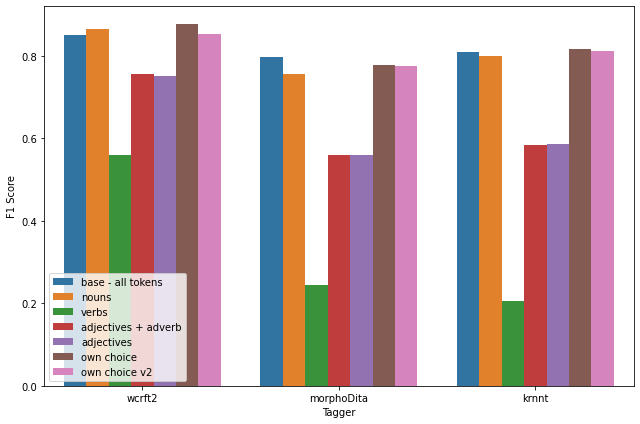

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
sns.barplot(x="tagger", y="f1", data=df_results, hue='desc')
plt.legend(loc='lower left')
plt.xlabel("Tagger")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.savefig("../figures/results_taggers_hue_desc.png")

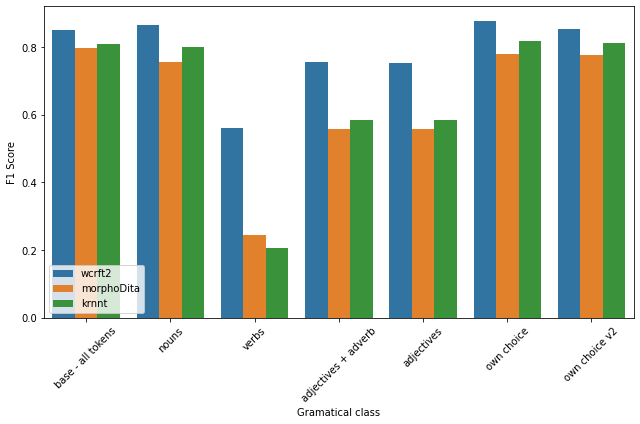

In [76]:
plt.figure(figsize=(9, 6))
plt.xticks(rotation=45)
sns.barplot(x="desc", y="f1", data=df_results, hue='tagger')
plt.legend(loc='lower left')
plt.xlabel("Gramatical class")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.savefig("../figures/results_taggers_hue_gram_class.png")

### Grid search

In [50]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
    'vect__min_df': (1, 3)
}

In [51]:
gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

In [52]:
gs_data = data_base[(data_base["tagger"] == 'wcrft2') & (data_base["set"] == 'train')]

gs_clf = gs_clf.fit(gs_data.filtered_tokens_text, gs_data.cat)

In [53]:
print(gs_clf.best_score_)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.8945533769063181
clf__alpha: 0.01
tfidf__use_idf: True
vect__min_df: 3
vect__ngram_range: (1, 1)


In [54]:
gs_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3)),
    ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True)),
    ('clf', MultinomialNB(alpha=1e-2))
])

In [55]:
df_results_gs = compare_results(
    pipeline=gs_pipeline,
    datasets=datasets,
    descriptions=description,
)

Procssing base - all tokens
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing nouns
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing verbs
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing adjectives + adverb
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing adjectives
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing own choice
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt
Procssing own choice v2
	Procssing wcrft2
	Procssing morphoDita
	Procssing krnnt


In [56]:
df_results_gs

,desc,f1,acc,prec,rec,tagger
0,base - all tokens,0.896280,0.897358,0.902120,0.899432,wcrft2
1,base - all tokens,0.803019,0.803118,0.808271,0.806773,morphoDita
2,base - all tokens,0.808730,0.811314,0.813053,0.815283,krnnt
3,nouns,0.888100,0.890244,0.892899,0.890893,wcrft2
4,nouns,0.745243,0.737805,0.772226,0.741987,morphoDita
5,nouns,0.776830,0.777439,0.791599,0.782849,krnnt
6,verbs,0.593637,0.605352,0.607703,0.600217,wcrft2
7,verbs,0.245019,0.212060,0.333446,0.211906,morphoDita
8,verbs,0.209128,0.173442,0.335742,0.174802,krnnt
9,adjectives + adverb,0.777590,0.780149,0.784685,0.779343,wcrft2


In [57]:
df_results_gs['version'] = 'grid search'
df_results['version'] = 'base'

df_results_compare = pd.concat([df_results_gs, df_results])

df_results_compare[df_results_compare['tagger'] == 'wcrft2']

,desc,f1,acc,prec,rec,tagger,version
0,base - all tokens,0.896280,0.897358,0.902120,0.899432,wcrft2,grid search
3,nouns,0.888100,0.890244,0.892899,0.890893,wcrft2,grid search
6,verbs,0.593637,0.605352,0.607703,0.600217,wcrft2,grid search
9,adjectives + adverb,0.777590,0.780149,0.784685,0.779343,wcrft2,grid search
12,adjectives,0.770998,0.775068,0.778847,0.773676,wcrft2,grid search
15,own choice,0.895489,0.897358,0.901291,0.898157,wcrft2,grid search
18,own choice v2,0.890285,0.891938,0.896966,0.892358,wcrft2,grid search
0,base - all tokens,0.850803,0.861111,0.890874,0.852817,wcrft2,base
3,nouns,0.864742,0.872967,0.890544,0.866365,wcrft2,base
6,verbs,0.560260,0.574526,0.632662,0.568319,wcrft2,base


In [79]:
print(round(df_results_compare[df_results_compare['tagger'] == 'wcrft2'], 4).to_latex())

\begin{tabular}{llrrrrll}
\toprule
{} &                 desc &      f1 &     acc &    prec &     rec &  tagger &      version \\
\midrule
0  &    base - all tokens &  0.8963 &  0.8974 &  0.9021 &  0.8994 &  wcrft2 &  grid search \\
3  &                nouns &  0.8881 &  0.8902 &  0.8929 &  0.8909 &  wcrft2 &  grid search \\
6  &                verbs &  0.5936 &  0.6054 &  0.6077 &  0.6002 &  wcrft2 &  grid search \\
9  &  adjectives + adverb &  0.7776 &  0.7801 &  0.7847 &  0.7793 &  wcrft2 &  grid search \\
12 &           adjectives &  0.7710 &  0.7751 &  0.7788 &  0.7737 &  wcrft2 &  grid search \\
15 &           own choice &  0.8955 &  0.8974 &  0.9013 &  0.8982 &  wcrft2 &  grid search \\
18 &        own choice v2 &  0.8903 &  0.8919 &  0.8970 &  0.8924 &  wcrft2 &  grid search \\
0  &    base - all tokens &  0.8508 &  0.8611 &  0.8909 &  0.8528 &  wcrft2 &         base \\
3  &                nouns &  0.8647 &  0.8730 &  0.8905 &  0.8664 &  wcrft2 &         base \\
6  &            

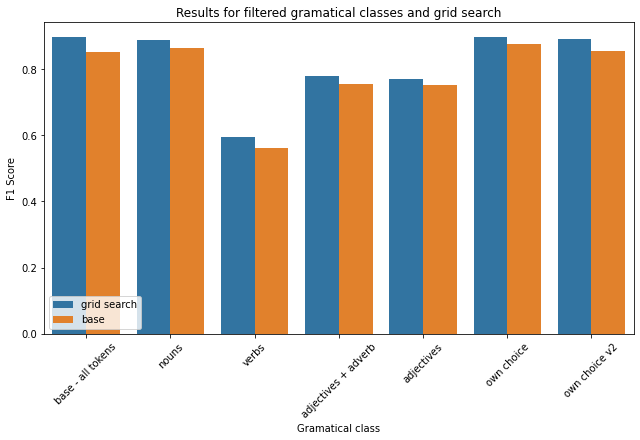

In [75]:
plt.figure(figsize=(9, 6))
plt.xticks(rotation=45)
sns.barplot(x="desc", y="f1", data=df_results_compare[df_results_compare['tagger'] == 'wcrft2'], hue='version')
plt.legend(loc='lower left')
plt.xlabel("Gramatical class")
plt.ylabel("F1 Score")
plt.tight_layout()
_ = plt.title("Results for filtered gramatical classes and grid search")
plt.savefig("../figures/results_taggers_hue_grid_search.png")

In [62]:
tagger_data = data_base[data_base['tagger'] == 'wcrft2']
train = tagger_data[tagger_data['set'] == 'train']
test = tagger_data[tagger_data['set'] == 'test']
train_X = train['filtered_tokens_text'].values
train_y = train['cat']
test_X = test['filtered_tokens_text'].values
test_y = test['cat']
gs_pipeline.fit(train_X, train_y)
preds = gs_pipeline.predict(test_X)

In [92]:
print(round(pd.DataFrame(metrics.classification_report(y_true=test_y, y_pred=preds, output_dict=True)).transpose(), 2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Albania                           &       0.94 &    0.80 &      0.87 &     92.0 \\
Amerykanscy-prozaicy              &       0.81 &    0.98 &      0.89 &    103.0 \\
Arabowie                          &       0.85 &    0.88 &      0.87 &     33.0 \\
Astronautyka                      &       0.87 &    0.87 &      0.87 &     93.0 \\
Choroby                           &       0.93 &    0.86 &      0.90 &     81.0 \\
Egipt                             &       0.88 &    0.78 &      0.83 &     92.0 \\
Ekologia-roslin                   &       0.87 &    0.93 &      0.90 &     86.0 \\
Filmy-animowane                   &       0.91 &    0.86 &      0.88 &     92.0 \\
Galezie-prawa                     &       0.94 &    0.52 &      0.67 &     90.0 \\
Gry-komputerowe                   &       0.95 &    0.90 &      0.92 &     98.0 \\
Karkonosze                        &       0.96 &    0.96 &      0.96 &     82

In [90]:
print(metrics.classification_report(y_true=test_y, y_pred=preds))

                                   precision    recall  f1-score   support

                          Albania       0.94      0.80      0.87        92
             Amerykanscy-prozaicy       0.81      0.98      0.89       103
                         Arabowie       0.85      0.88      0.87        33
                     Astronautyka       0.87      0.87      0.87        93
                          Choroby       0.93      0.86      0.90        81
                            Egipt       0.88      0.78      0.83        92
                  Ekologia-roslin       0.87      0.93      0.90        86
                  Filmy-animowane       0.91      0.86      0.88        92
                    Galezie-prawa       0.94      0.52      0.67        90
                  Gry-komputerowe       0.95      0.90      0.92        98
                       Karkonosze       0.96      0.96      0.96        82
                       Katolicyzm       0.75      0.98      0.85        84
                        